In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import os
from datetime import datetime, timedelta
from dask.distributed import Client
from datetime import datetime
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:24894,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.71 GiB
Comm: tcp://127.0.0.1:24916,Total threads: 3
Dashboard: http://127.0.0.1:24917/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:24899,


In [3]:
def map_datetime(dstr):
    mapper = {'Jan': 1,
              'Feb': 2,
              'Mar': 3,
              'Apr': 4,
              'May': 5,
              'Jun': 6,
              'Jul': 7,
              'Aug': 8,
              'Sep': 9,
              'Oct': 10,
              'Nov': 11,
              'Dec': 12}
    return datetime(*map(int, [dstr['variable'][7:11], mapper[dstr['variable'][3:6]], dstr['variable'][:2], dstr.name[1:3], dstr.name[4:6], dstr.name[7:9]]))

In [4]:
residencies = ['01', '02', '03', '04', '05', '06']
sm_columns = ['PowerAllPhases', 'PowerL1', 'PowerL2', 'PowerL3', 'CurrentNeutral', 'CurrentL1', 'CurrentL2', 'CurrentL3', 'VoltageL1', 'VoltageL2', 'VoltageL3', 'PhaseAngleVoltageL2L1', 'PhaseAngleVoltageL3L1', 'PhaseAngleCurrentVoltageL1', 'PhaseAngleCurrentVoltageL2', 'PhaseAngleCurrentVoltageL3']
sm_columns_dtypes = ['float64' for _ in range(11)]+['int64' for _ in range(5)]
appliances = ['Fridge', 'Dryer', 'CoffeeMachine', 'Kettle', 'WashingMachine', 'PC', 'Freezer', 'Timestamp']

In [5]:
for residency in residencies[4:5]:
    sm_path = os.path.join('../../data/ECO/Residency '+residency, residency+'_sm_csv', residency)
    sm_files = os.listdir(sm_path)
    residency_df = dd.from_pandas(pd.DataFrame(columns=sm_columns+['Timestamp']), npartitions=6)
    for file in sm_files:
        sm_file = pd.read_csv(os.path.join(sm_path, file), header=None, names=sm_columns, dtype={x: y for x,y in zip(sm_columns, sm_columns_dtypes)})
        year, month, day = file[:-4].split('-')
        sm_file['Timestamp'] = pd.Series([datetime(year=int(year), month=int(month), day=int(day))+timedelta(seconds=int(i)) for i in range(86400)])
        residency_df = dd.concat([residency_df, dd.from_pandas(sm_file, npartitions=6)])
    residency_df = residency_df.set_index('Timestamp', sorted=True)

    #plugs_path = os.path.join('./data/ECO/Residency '+residency, residency+'_plugs_csv', residency)
    #plugs_folders = os.listdir(plugs_path)
    #plugs_df = dd.from_pandas(pd.DataFrame(), npartitions=6)
    #for i, (folder, appliance) in enumerate(zip(plugs_folders, appliances)):
    #    appliance_df = pd.DataFrame(columns=[appliance])
    #    for file in os.listdir(os.path.join(plugs_path, folder))[44:46]:
    #        plugs_file = pd.read_csv(os.path.join(plugs_path, folder, file), header=None, names=[appliance], dtype={appliance: 'float64'})
    ###        year, month, day = file[:-4].split('-')
     #       plugs_file['Timestamp'] = pd.Series([datetime(year=int(year), month=int(month), day=int(day))+timedelta(seconds=int(i)) for i in range(86400)])
     #       appliance_df = pd.concat([appliance_df, plugs_file])
     #   appliance_df.set_index('Timestamp', inplace=True)
     #   if i==0:
     #       plugs_df = dd.from_pandas(appliance_df, npartitions=6)
     #   plugs_df[appliance] = appliance_df[appliance]

    occupancy_df1 = pd.read_csv(os.path.join('../../data/ECO/Residency '+residency, residency+'_occupancy_csv', residency+'_summer.csv'), index_col=0)
    occupancy_df2 = pd.read_csv(os.path.join('../../data/ECO/Residency '+residency, residency+'_occupancy_csv', residency+'_winter.csv'), index_col=0)
    occupancy_df = pd.concat([occupancy_df1, occupancy_df2], axis=0)
    occupancy_df = occupancy_df.transpose()
    occupancy_df1, occupancy_df2 = None, None
    melted_df = occupancy_df.melt(value_vars=occupancy_df.columns, ignore_index=False)
    melted_df['variable'] = melted_df.apply(map_datetime, axis=1)
    melted_df.set_index('variable', inplace=True)
    melted_df['value'] = melted_df['value'].astype(bool)
    melted_df = dd.from_pandas(melted_df, npartitions=6)
    total_residency_df = dd.concat([residency_df, melted_df], axis=1)
    total_residency_df = total_residency_df.dropna().compute()
    total_residency_df = total_residency_df.iloc[::30]
    total_residency_df.to_csv(os.path.join('../../data/ECO/Residency '+residency, residency+'_total.csv'))

2022-12-20 11:51:59,973 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:24913'.


In [13]:
csv1 = pd.read_csv('../../data/ECO/Residency 01/01_total.csv')
csv1['Residency'] = 'Residency 01'
csv2 = pd.read_csv('../../data/ECO/Residency 02/02_total.csv')
csv2['Residency'] = 'Residency 02'
csv3 = pd.read_csv('../../data/ECO/Residency 03/03_total.csv')
csv3['Residency'] = 'Residency 03'
csv4 = pd.read_csv('../../data/ECO/Residency 04/04_total.csv')
csv4['Residency'] = 'Residency 04'
csv5 = pd.read_csv('../../data/ECO/Residency 05/05_total.csv')
csv5['Residency'] = 'Residency 05'

In [14]:
total_csv = pd.concat([csv1, csv2, csv3, csv4, csv5], sort=False)
total_csv = total_csv.rename(columns={'Unnamed: 0': 'Timestamp'})
total_csv = total_csv.sort_values(by=['Timestamp', 'Residency'])
total_csv.to_csv('../../data/ECO/combined.csv', index=False)

In [10]:
from sklearn.decomposition import PCA, NMF
import pandas as pd
from sklearn.impute import KNNImputer

In [19]:
total_csv = pd.read_csv('../../data/ECO/combined.csv')
total_csv = total_csv.loc[:, ~total_csv.columns.isin(['PhaseAngleVoltageL2L1', 'PhaseAngleVoltageL3L1'])]
pct_null = total_csv.isnull().sum() / len(total_csv)
missing_features = pct_null[pct_null > 0.20].index
total_csv.drop(missing_features, axis=1, inplace=True)
total_csv = total_csv.astype({'PhaseAngleCurrentVoltageL1': 'float64', 'PhaseAngleCurrentVoltageL2': 'float64', 'PhaseAngleCurrentVoltageL3': 'float64'})
num_mask = total_csv.dtypes == float
total_csv.loc[:, num_mask] = total_csv.loc[:, num_mask].mask(total_csv.loc[:, num_mask] < 0, 0)
total_csv["Timestamp"] = pd.to_datetime(total_csv["Timestamp"])
total_csv["Hour"] = total_csv["Timestamp"].dt.hour
filtered = pd.get_dummies(total_csv, columns=["Hour"])
filtered = filtered.loc[:, ~filtered.columns.isin(['Timestamp', 'Residency', 'value'])]
imputer = KNNImputer(n_neighbors=4, weights="uniform")
filtered = imputer.fit_transform(filtered)
pca_result = PCA(n_components=2).fit_transform(filtered)
total_csv['PCA 1'] = pca_result[:, 0]
total_csv['PCA 2'] = pca_result[:, 1]
nmf = NMF(n_components=2).fit_transform(filtered)
total_csv['NMF 1'] = nmf[:, 0]
total_csv['NMF 2'] = nmf[:, 1]
total_csv.loc[:, ~total_csv.columns.isin(['Hour'])].to_csv('../../data/ECO/combined.csv', index=False)

# Preprocessing and cleaning

In [3]:
total_csv = pd.read_csv('../../data/ECO/combined.csv')
mask = (total_csv['Residency']=='Residency 01') | (total_csv['Residency']=='Residency 02') | (total_csv['Residency']=='Residency 03')

In [4]:
## Filter the voltage levels that are below 200, set them to NaN that are later going to be imputed by imputers
total_csv.loc[total_csv['VoltageL1']<200, 'VoltageL1'] = np.nan
total_csv.loc[total_csv['VoltageL2']<200, 'VoltageL2'] = np.nan
total_csv.loc[(total_csv['VoltageL3']<200) & (total_csv['Residency'] != 'Residency 02'), 'VoltageL3'] = np.nan
total_csv.loc[total_csv['Residency'] == 'Residency 02', 'VoltageL3'] = 235.0

## Set the voltage/current angles between [-180, 180] instead of [0, 360]
total_csv.loc[total_csv['PhaseAngleCurrentVoltageL1']>180, 'PhaseAngleCurrentVoltageL1'] = total_csv.loc[total_csv['PhaseAngleCurrentVoltageL1']>180, 'PhaseAngleCurrentVoltageL1'].astype(float)-360
total_csv.loc[total_csv['PhaseAngleCurrentVoltageL2']>180, 'PhaseAngleCurrentVoltageL2'] = total_csv.loc[total_csv['PhaseAngleCurrentVoltageL2']>180, 'PhaseAngleCurrentVoltageL2'].astype(float)-360
total_csv.loc[total_csv['PhaseAngleCurrentVoltageL3']>180, 'PhaseAngleCurrentVoltageL3'] = total_csv.loc[total_csv['PhaseAngleCurrentVoltageL3']>180, 'PhaseAngleCurrentVoltageL3'].astype(float)-360

In [5]:
# Impute the NaN Values:
print('Current number of NaN rows: ', total_csv.isna().sum().sum())
imputer = KNNImputer(n_neighbors=4, weights="uniform")
filtered = imputer.fit_transform(total_csv.select_dtypes(['number']))

Current number of NaN rows:  7846


In [6]:
total_csv[total_csv.select_dtypes(['number']).columns] = filtered
print('Current number of NaN rows: ', total_csv.isna().sum().sum())

Current number of NaN rows:  0


In [7]:
train_df = total_csv[mask]
test_df = total_csv[-mask]

In [8]:
from sklearn.preprocessing import StandardScaler

# Standardize voltage levels because it looks like a shifted normal
v1_scaler = StandardScaler().fit(train_df['VoltageL1'].to_numpy().reshape(-1, 1))
total_csv['VoltageL1'] = v1_scaler.transform(total_csv['VoltageL1'].to_numpy().reshape(-1, 1))

v2_scaler = StandardScaler().fit(train_df['VoltageL2'].to_numpy().reshape(-1, 1))
total_csv['VoltageL2'] = v2_scaler.transform(total_csv['VoltageL2'].to_numpy().reshape(-1, 1))

v3_scaler = StandardScaler().fit(train_df['VoltageL3'].to_numpy().reshape(-1, 1))
total_csv['VoltageL3'] = v3_scaler.transform(total_csv['VoltageL3'].to_numpy().reshape(-1, 1))

# Sqrt transform the power and the current
total_csv['CurrentL1'] = np.sqrt(total_csv['CurrentL1'])
total_csv['CurrentL2'] = np.sqrt(total_csv['CurrentL2'])
total_csv['CurrentL3'] = np.sqrt(total_csv['CurrentL3'])
total_csv['CurrentNeutral'] = np.sqrt(total_csv['CurrentNeutral'])
total_csv['PowerL1'] = np.sqrt(total_csv['PowerL1'])
total_csv['PowerL2'] = np.sqrt(total_csv['PowerL2'])
total_csv['PowerL3'] = np.sqrt(total_csv['PowerL3'])
total_csv['PowerAllPhases'] = np.sqrt(total_csv['PowerAllPhases'])

# Normalize the angles
v1_scaler = StandardScaler().fit(train_df['PhaseAngleCurrentVoltageL1'].to_numpy().reshape(-1, 1))
total_csv['PhaseAngleCurrentVoltageL1'] = v1_scaler.transform(total_csv['PhaseAngleCurrentVoltageL1'].to_numpy().reshape(-1, 1))

v1_scaler = StandardScaler().fit(train_df['PhaseAngleCurrentVoltageL2'].to_numpy().reshape(-1, 1))
total_csv['PhaseAngleCurrentVoltageL2'] = v1_scaler.transform(total_csv['PhaseAngleCurrentVoltageL2'].to_numpy().reshape(-1, 1))

v1_scaler = StandardScaler().fit(train_df['PhaseAngleCurrentVoltageL3'].to_numpy().reshape(-1, 1))
total_csv['PhaseAngleCurrentVoltageL3'] = v1_scaler.transform(total_csv['PhaseAngleCurrentVoltageL3'].to_numpy().reshape(-1, 1))

In [9]:
total_csv = total_csv.drop(['PCA 1', 'PCA 2', 'NMF 1', 'NMF 2'], axis=1)
total_csv.to_csv('../../data/ECO/combined_cleaned.csv', index=False)

### Adding datetime features

In [10]:
total_csv = pd.read_csv('../../data/ECO/combined_cleaned.csv')
total_csv['value'] = total_csv['value'].astype(float)

In [11]:
def convert_timestamp_to_datetime(timestamp_string):
    return datetime.strptime(timestamp_string, "%Y-%m-%d %H:%M:%S")

total_csv['Timestamp'] = total_csv['Timestamp'].apply(convert_timestamp_to_datetime)
total_csv['Hour'] = total_csv['Timestamp'].apply(lambda x: x.hour)

one_hot = pd.get_dummies(total_csv['Hour'])
total_csv.drop('Hour', axis=1, inplace=True)
total_csv = pd.concat([total_csv, one_hot], axis=1)

In [12]:
total_csv.to_csv('../../data/ECO/combined_cleaned.csv')

### Adding 15 and 30 minute occupancy information

In [3]:
total_csv = pd.read_csv('../../data/ECO/combined_cleaned.csv')
def convert_timestamp_to_datetime(timestamp_string):
    return datetime.strptime(timestamp_string, "%Y-%m-%d %H:%M:%S")
total_csv['Timestamp'] = total_csv['Timestamp'].apply(convert_timestamp_to_datetime)
total_csv['Occupancy15Min'] = 0
total_csv['Occupancy30Min'] = 0

for residency in ['Residency 01', 'Residency 02', 'Residency 03', 'Residency 04', 'Residency 05']:
    room_df = total_csv.loc[total_csv['Residency'] == residency, :]
    lagged_15 = room_df['value'].shift(-30)
    difference_15 = -room_df['Timestamp'].diff(periods=-30)
    indices_15 = difference_15 != timedelta(minutes=15)
    lagged_15[indices_15] = -1
    total_csv.loc[total_csv['Residency'] == residency, 'Occupancy15Min'] = lagged_15

    lagged_30 = room_df['value'].shift(-60)
    difference_30 = -room_df['Timestamp'].diff(periods=-60)
    indices_30 = difference_30 != timedelta(minutes=30)
    lagged_30[indices_30] = -1
    total_csv.loc[total_csv['Residency'] == residency, 'Occupancy30Min'] = lagged_30

total_csv.to_csv('../../data/ECO/combined_cleaned.csv')

# Feature Scoring

Text(0.5, 1.0, 'Correlation Matrix')

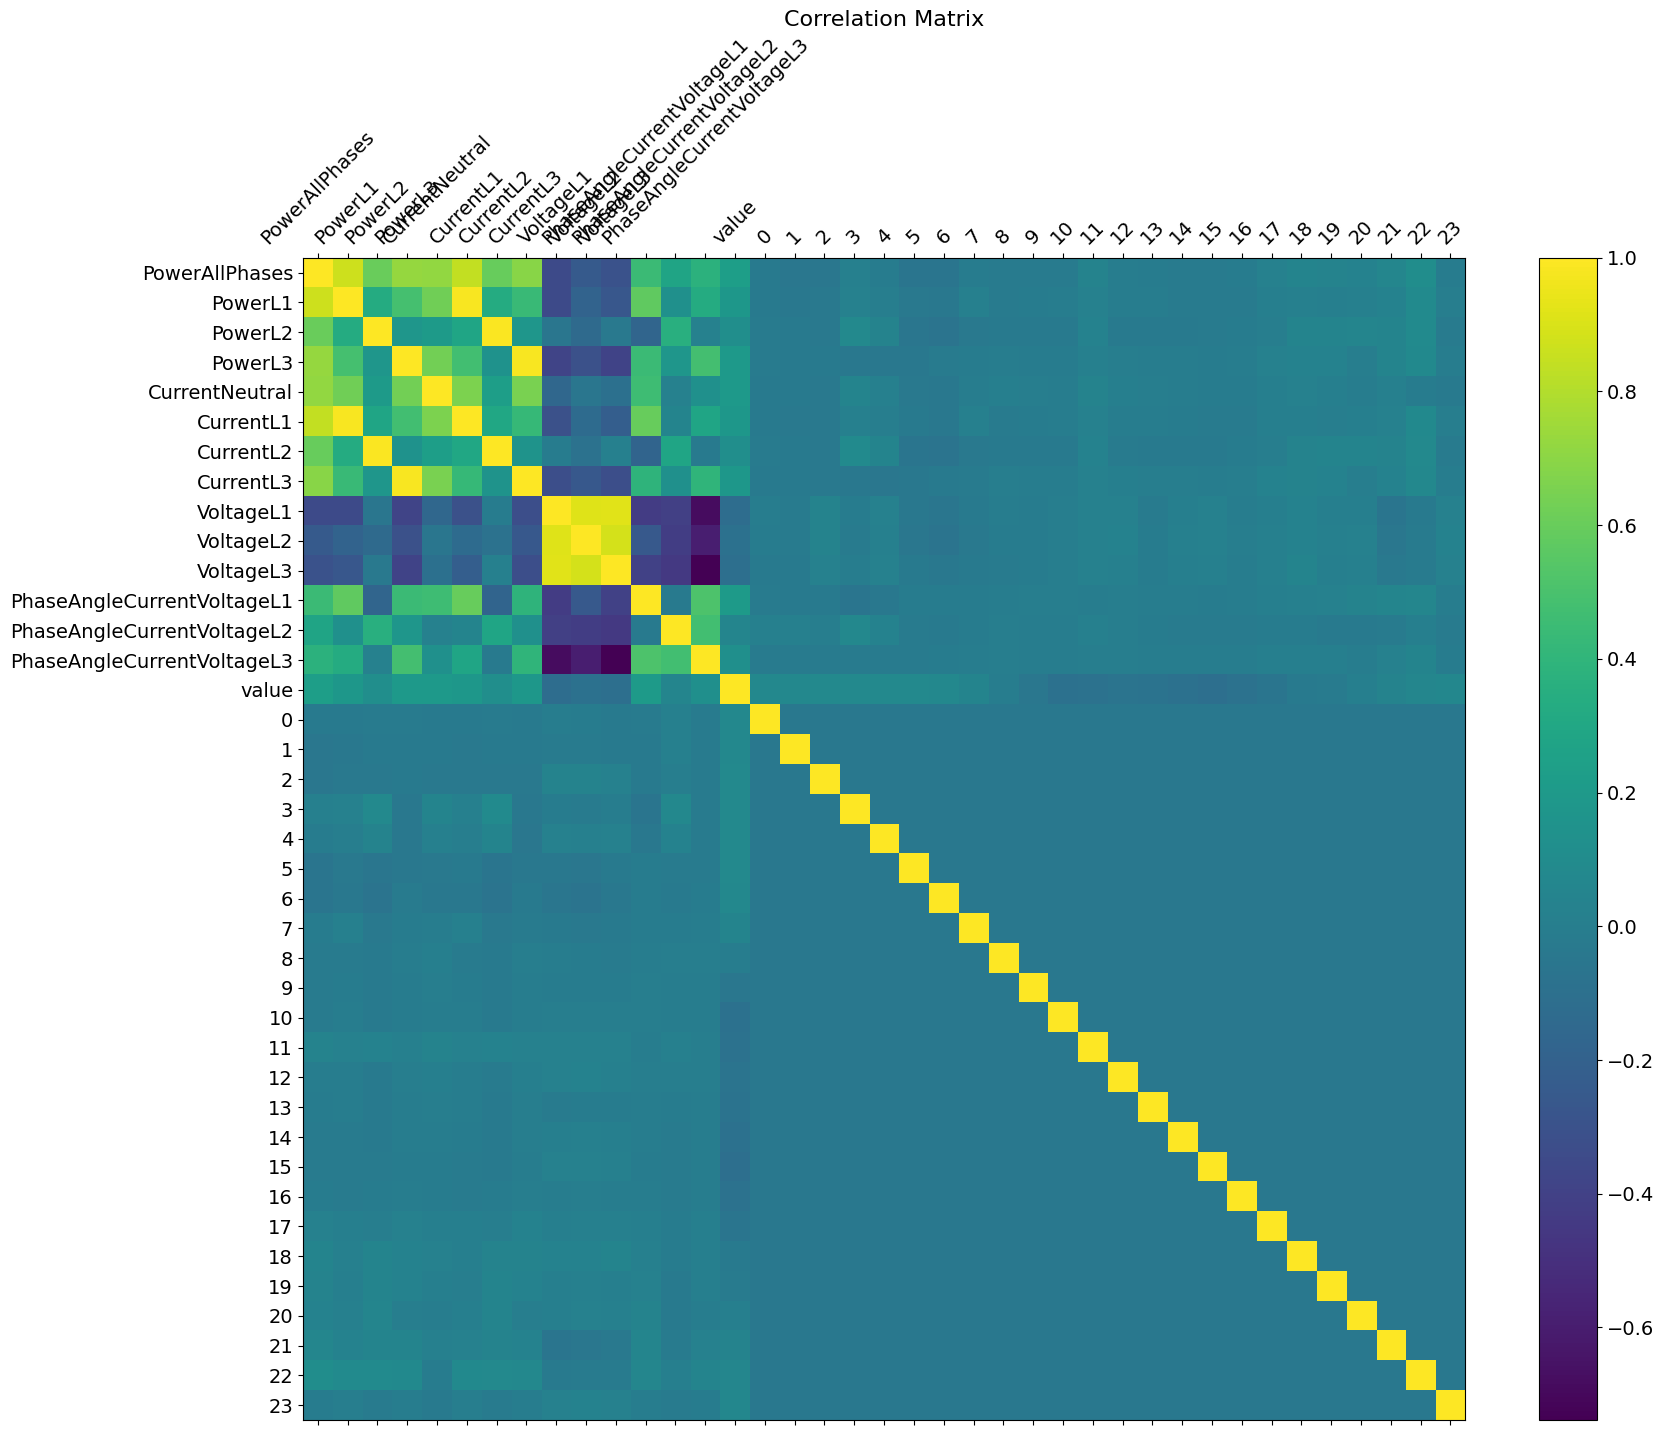

In [4]:
f = plt.figure(figsize=(19, 15))
plt.matshow(total_csv.select_dtypes(['number']).corr(), fignum=f.number)
plt.xticks(range(total_csv.select_dtypes(['number']).shape[1]), total_csv.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(total_csv.select_dtypes(['number']).shape[1]), total_csv.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [8]:
mask = (total_csv['Residency']=='Residency 01') | (total_csv['Residency']=='Residency 02') | (total_csv['Residency']=='Residency 03')
train_df = total_csv[mask].drop(['Residency', 'Timestamp', 'Occupancy15Min', 'Occupancy30Min'], axis=1)

Feature: PowerAllPhases, Score: 0.01716
Feature: PowerL1, Score: 0.00830
Feature: PowerL2, Score: 0.00701
Feature: PowerL3, Score: 0.00783
Feature: CurrentNeutral, Score: 0.01250
Feature: CurrentL1, Score: 0.00680
Feature: CurrentL2, Score: 0.01211
Feature: CurrentL3, Score: 0.01784
Feature: VoltageL1, Score: 0.00236
Feature: VoltageL2, Score: 0.00307
Feature: VoltageL3, Score: 0.00308
Feature: PhaseAngleCurrentVoltageL1, Score: 0.01079
Feature: PhaseAngleCurrentVoltageL2, Score: 0.01066
Feature: PhaseAngleCurrentVoltageL3, Score: 0.01337
Feature: 0, Score: 0.07334
Feature: 1, Score: 0.09721
Feature: 2, Score: 0.08120
Feature: 3, Score: 0.08846
Feature: 4, Score: 0.08137
Feature: 5, Score: 0.05900
Feature: 6, Score: 0.07744
Feature: 7, Score: 0.02889
Feature: 8, Score: 0.00978
Feature: 9, Score: 0.00559
Feature: 10, Score: 0.01259
Feature: 11, Score: 0.02907
Feature: 12, Score: 0.01743
Feature: 13, Score: 0.01113
Feature: 14, Score: 0.02450
Feature: 15, Score: 0.03273
Feature: 16, Scor

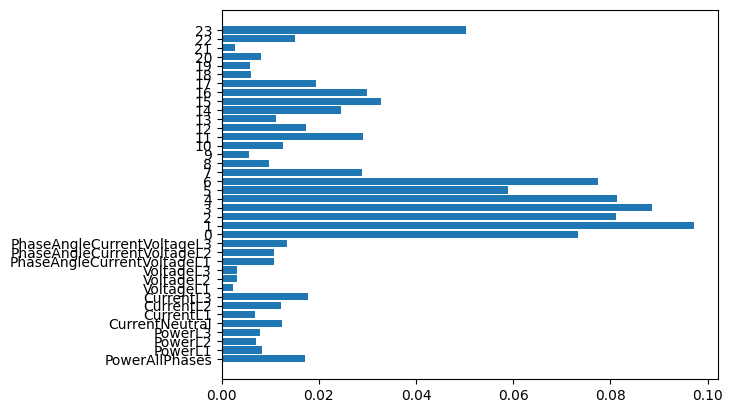

In [11]:
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
# define dataset
y = train_df['value']
X = train_df.loc[:, train_df.columns != 'value']
#X.columns = [s.translate({ord(i): None for i in '[]<'}) for s in X.columns]
# define the model
model = XGBClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for (i,v), names in zip(enumerate(importance), X.columns):
 print(f'Feature: {names}, Score: {v:.5f}')
# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.yticks(ticks=range(0,len(X.columns)), labels=X.columns)
plt.show()